In [1]:
# std python utility
from pathlib import Path
from collections import Counter
import os
# ds utility
import pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# ds modelling
import sklearn

import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.set_option('display.max_columns', None)

In [2]:
# directory setup
ROOT = Path(os.getcwd())
DATA_DIR = ROOT / "input"
display(ROOT, DATA_DIR)
os.listdir(DATA_DIR)

WindowsPath('C:/Users/hlao1/Github/kaggle-titanic')

WindowsPath('C:/Users/hlao1/Github/kaggle-titanic/input')

['gender_submission.csv', 'test.csv', 'train.csv']

# Exploratory Data Analysis

In [3]:
# Load datasets
train = pd.read_csv(DATA_DIR/"train.csv")
test = pd.read_csv(DATA_DIR/"test.csv")
# surface level inspection of the training data loaded
display(train.head())
# display general info about the dataset
display(train.info())
# observe general stats of feat-cols 
display(train.describe())

feat_cols = train.columns.to_list()
display(feat_cols)
print("Number of features:",len(feat_cols))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

Number of features: 12


In [4]:
# remove passengerId which is simply used for maintaining training instance indices ie an non impactful column in terms of the classificaiton problem
train_ids = train["PassengerId"]
train = train.drop(labels="PassengerId",axis=1)
# 
feat_cols = train.columns.to_list()
display(feat_cols)
print("Number of features:",len(feat_cols))

['Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

Number of features: 11


In [5]:
sample_submission = pd.read_csv(DATA_DIR / "gender_submission.csv")
sample_submission.head() # classification problem of predicting the target feat-col: "survived"

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Data Description
| Variable | Definition | Key |
|----------|-----------|------|
|survival	|Survival|	0 = No, 1 = Yes|
|pclass	|Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	||
|Age|	Age in years	||
|sibsp|	# of siblings / spouses aboard the Titanic	||
|parch	|# of parents / children aboard the Titanic	||
|ticket	|Ticket number	||
|fare|	Passenger fare	||
|cabin|	Cabin number	||
|embarked|	Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|

# Variable Notes
pclass: A proxy for socio-economic status (SES)<br>
1st = Upper <br>
2nd = Middle<br>
3rd = Lower<br>

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br>

sibsp: The dataset defines family relations in this way...<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)<br>

parch: The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.<br>


# Initial Thoughts on Plan of Action
Objective: Predict the target variable "survived" using the classification problem's data set "train.csv" provided.
1. Inspect in further detail of the given features via plots
2. Evaluate methods of plotting and select appropriate method for the data type
3. Look out for anomalies such as: non-Gaussian distros, outliers
4. Observe variables' dependencies/relations using covar matrix -- a "heat map"
5. Understand data types to be worked with

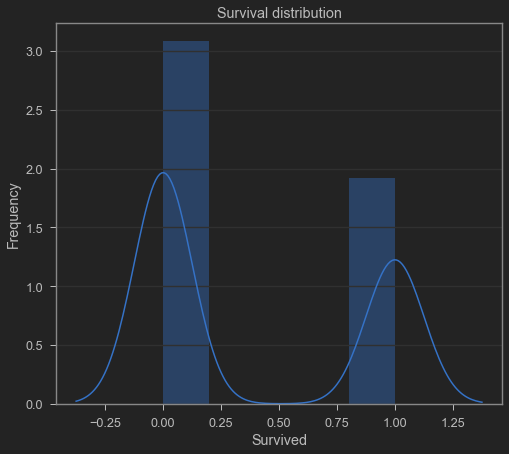

Skewness: 0.478523
Kurtosis: -1.775005


In [6]:
# attempt to plot target variable
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['Survived'], color="b");
ax.set(ylabel="Frequency")
ax.set(xlabel="Survived")
ax.set(title="Survival distribution")
# sns.despine(trim=True, left=True)
plt.grid(True)
ax.xaxis.grid(False)

plt.show()
print("Skewness: %f" % train['Survived'].skew())
print("Kurtosis: %f" % train['Survived'].kurt())

The chosen distribution plot method does not appear to display the data in a manner that is meaningful -- perhaps there isn't much to be drawn from the individual target variable itself outside of the fact that more people died than those that survived. Alternative plot methods could be either a scatter plot or a box plot. The double distribution curves are expected given the discrete nature of the variable ( 0 or 1 ie dead or alive)

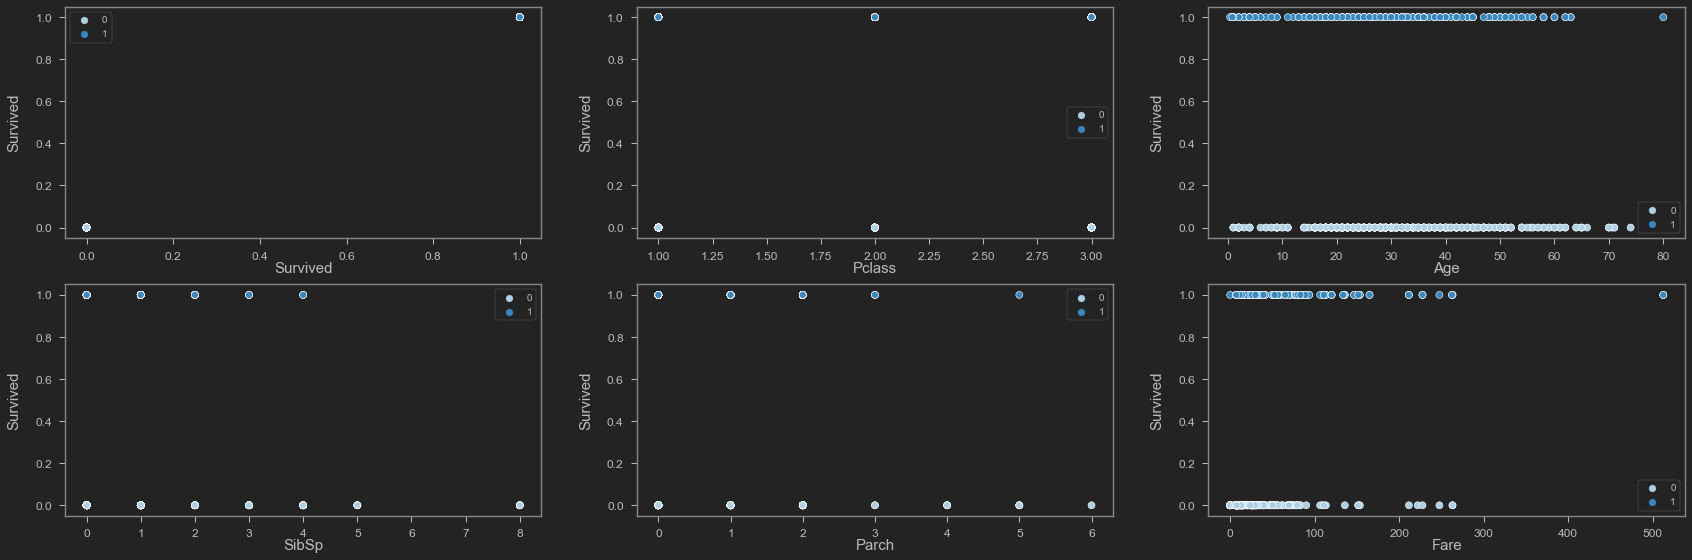

In [7]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
#         if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
#             pass
#         else:
        numeric.append(i)     

# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,12))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='Survived', hue='Survived', palette='Blues', data=train)
    plt.xlabel('{}'.format(feature), size=15,labelpad=0)
    plt.ylabel('Survived', size=15, labelpad=14)
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    plt.legend(loc='best', prop={'size': 10})
plt.show()


Not sure what conclusions I can draw given these plots. Perhaps a boxplot

In [8]:
# data = pd.concat([train['Survived'], train['Age']], axis=1)
# f, ax = plt.subplots(figsize=(8,8))
# fig = sns.boxplot(x=train['Age'], y="Survived", data=data)
# plt.xticks(rotation=45)
# # fig.axis(ymin=train['Survived'].min(), ymax=train['Survived'].max());
# plt.show()


Still uncertain about what to make of the data. The rationale for plotting these particular features were based upon a linear regression problem in which numeric datatypes were plotted. In this particular case, it's clear that plotting numerics against a label does not show all too much. Perhaps a distribution plot applied to all features would be more useful?

In [9]:

# # visualising some more outliers in the data values
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,12))
# plt.subplots_adjust(right=2)
# plt.subplots_adjust(top=2)
# sns.color_palette("husl", 8)
# for i, feature in enumerate(list(train[feat_cols]), 1):
#     plt.subplot(len(list(numeric)), 3, i)
#     g = sns.distplot(train[feature], color="m", label="Skewness : %.2f"%(train["Fare"].skew()))
#     g = g.legend(loc="best")
# plt.show()


# Feature vs Target Feature Analysis
* pclass vs survived
    * there appears to be a relation between passenger socioeconomic class and their rate of survival
    * upper-class passengers are more inclined to survive in contrast to lower-class passengers
* sex vs survived
    * women were far more likely to survive in contrast to males
* age vs survived
    * there appears to be a bit of a relation; however, requires further investigation
* siblings & spouses VS surived
    * passengers who had a larger party (spouses or siblings) were less inclined to survive
    * the cut off point appears to be at 2 siblings & spouses at which there appears to be a large drop off in the survival rate
* parch (# parents/children) vs survived:
    * no parent or child case appears to potentially be an outlier -- not sure about the reasonings as to why
    * the case of 1/2/3 parch sizes appear to make sense in terms of the survival rate of the passenger
    * not sure what to make meaining behind the portruding line drawn
* ticket number & survived:
    * there may be some information here in regards to how passengers were seated upon the ship; however, given the uniqueness of ticker numbers there cannot be any direct conclusions made about the relation between a passengers ticket nubmer and their survival rate
* fare vs survived
    * there is likely a relation here based upon the observations of pclass vs survival rate
    * a closer inspection is needed
* cabin vs survived
    * it is possible that there may be some correlation between survival rate given a passengers cabin number
    * this correlation is motivated by an understanidng of how ships hold multiple levels of cabins thus, the passengers at the lowest level cabins would likely not have been able to make it to the rafts sooner than the ones at the upper level
    * cabin and pclass may share a relation
    * cabin and fare may share a relation
* embarked vs survived
    * naturally inclined to think that the port of embarkation is likely to have little to no relation with survival rate
    * a case for a relation to exist would be that the location may represent a culture of alertness to dangers suggesting a better prepared passenger for moments of danger
    * what is the significance of the location of embarkation?
    * what is the reason for passengers who embarked at Cherbourg having a higher survival chance?
* survived vs survived
    * NA
* name vs survived
    * NA

<AxesSubplot:>

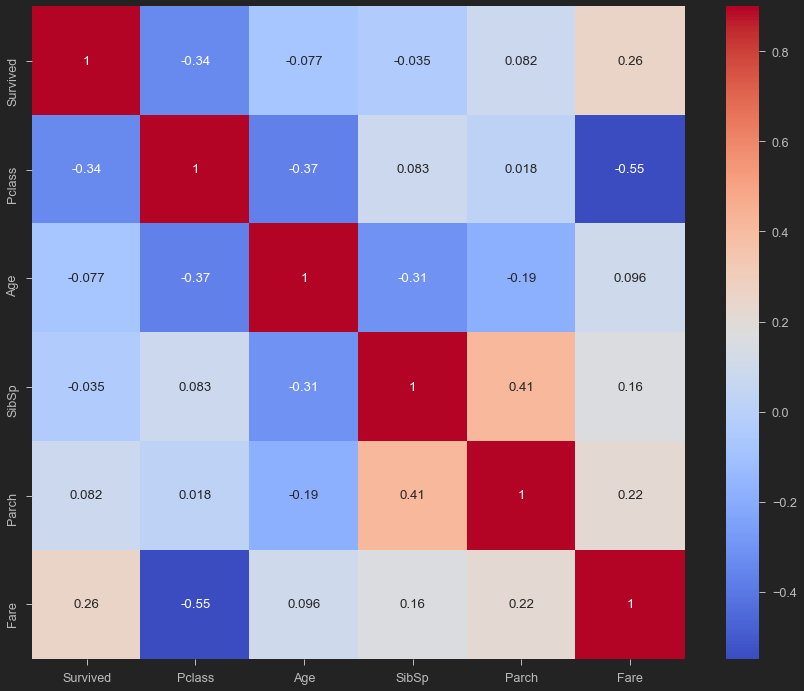

In [10]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="coolwarm", square=True, annot= True)


# Analysis
* We can see that there's a positive correlation between the training set's "Fare" and "Survived" rand variables
* "Parch" and "Fare" are very slightly positively correlated
* The rest of the features hold a slight negative correlation with "Survived"

# Feature Imputation
Does there exist any missing values? How many? How do we appropriately fill in for these missing values?

In [11]:
# Missing Features in Training Dataset
all_cols = train.isna().any()
na_cols = [c for c in all_cols.index if all_cols[c] == True]
display("All columns:",train.isna().any(), "Missing cols:", na_cols)
print()
for c in na_cols:
    na_count = train[c].isna().sum()
    total = len(train[c])
    na_percent =  na_count / total * 100
    print("{}: {} / {} instances missing --> {:1.5f}%".format(c, na_count, total, na_percent))

'All columns:'

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

'Missing cols:'

['Age', 'Cabin', 'Embarked']


Age: 177 / 891 instances missing --> 19.86532%
Cabin: 687 / 891 instances missing --> 77.10438%
Embarked: 2 / 891 instances missing --> 0.22447%


How do we go about feature imputation?'
* currently only observing just the training instances, need to impute for the set of ALL instances ie train + test dataset
* based upon the data description how would we create new features? consider 1 or more variables from which we can define a new feature>
    - for example: denoting whether the passenger is travelling alone or not
* apply KNN algorithm?


# Random Ideas
* Would we ever use PCA here? 
    - Considering that the dataset is extremely small in terms of the degree of dimnesions, there would be very little reason for applying a technique to reduce dimensionality
    - PCA may actually hurt the performance of the model
    - Worth exploring to provide concreteness/assessing these claims

# References for New Ideas/Perspectives
* <b>Python DS Framework</b>: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
    * <b>Notable sections:</b>
        - Problem Definition
        - Data Preparation
        - Meet & Greet the Data (EDA)
    * <b>My Takeaways & Reflection from Reading</b>
        - Nearly all of my intuitons & observations up to this point of the jupyter notebook were on-point with the notes defined in the "Meet & Greet the Data" section
        - Good Practice? make a copy rather of the data rather than altering it directly?
        - <b>4Cs of Data Cleaning</b>
            1. Correcting: adjust outlier values
            2. Completing: feature imputation ie filling in the non-existing values
            3. Creating: feature engineering ie utilize existing features to create new ones
            4. Converting: convert to dummy variables ie hot encode (Ex. conversion using a kv-mapping of strings to integer vals)?
        - Performing feature imputation: usage of median & mode
            - why median over average for "Age" & "Fare"? 
            - why mode for "Embarked"?
            - could we utilize the set of all instances that do not have missing columns from which we train a model to predict for the instances that contain missing values?
        - Performing feature engineering
            - Why do we use pd.qcut? What does it do? What was the rationale for qcutting for the features denoted in the notebook?
* <b>Python Ensemble Methods</b>: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    * <b>Notable Sections:</b>
        - Outlier Detection (Tukey Method)
    * <b>My Takeaways & Reflection from Reading</b>
        - Revealed my own weakness -- a need deepen my stats understaning in terms of the significance of outliers 
        - A need to understand methods of cleaning out data ie removal of outliers (what other forms exist outside of the Tukey method provided?)
            - Other outlier detection methods: https://towardsdatascience.com/practical-guide-to-outlier-detection-methods-6b9f947a161e
        - Usage of a <b>FacetGrid</b> from Seaborn in displaying age distribution and surival outcome
        - Usage of a <b>kdeplot</b> for overlaying the two plots pertaining to 2 survival outcomes on one chart
        - Approaching each datatype with the appropriate plotting method is so important
* <b>R Tutorial</b>: https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic
    * Organized very well
    * Provides alot of useful commentary for gaining insight into the steps taken

# Revisiting EDA

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [13]:
# create a dictionary dtype: column_names ie aggregate columns by their dtype
type_dict = {str(k): list(v) for k, v in train.groupby(train.dtypes, axis=1)}
type_dict

{'int64': ['Survived', 'Pclass', 'SibSp', 'Parch'],
 'float64': ['Age', 'Fare'],
 'object': ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']}

# int64: Feature vs Target Feature Analysis


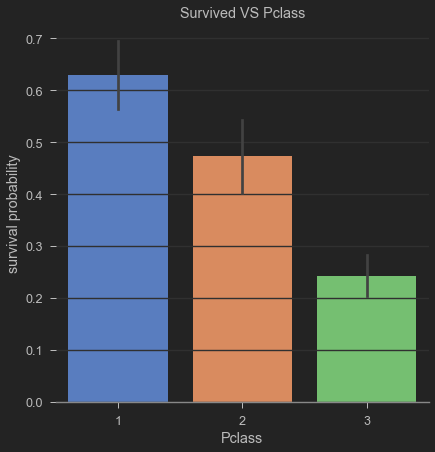

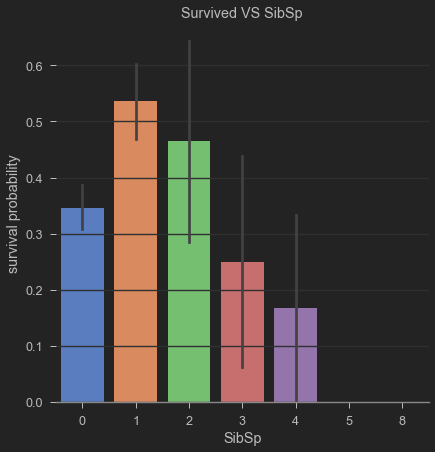

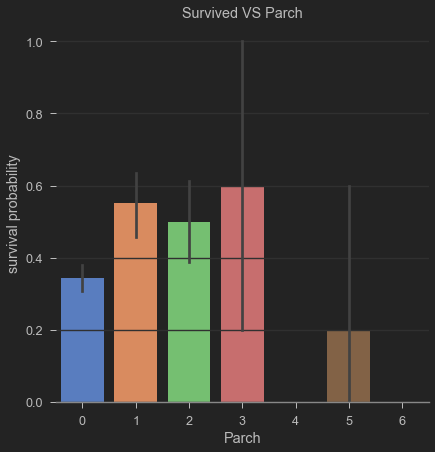

In [14]:
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,12))
# plt.subplots_adjust(right=2)
# plt.subplots_adjust(top=2)
for i, c in enumerate([ _ for _ in type_dict["int64"] if _ != "Survived"],1):
#     plt.subplot(len(list([ _ for _ in type_dict["int64"]if _ != "Survived"])), 2, i)
    g = sns.factorplot(x=c,y="Survived",data=train,kind="bar", size = 6 , 
    palette = "muted")
    g.despine(left=True)
    g = g.set_ylabels("survival probability")
    plt.grid(axis="y")
    plt.title("Survived VS {}".format(c))
plt.show()
# print(plt.grid.__doc__)
# need to learn how to create subplots when using seaborn

* Pclass VS Survived
    * there appears to be a relation between passenger socioeconomic class and their rate of survival
    * upper-class passengers are more inclined to survive in contrast to lower-class passengers
* SubSp VS Surived
    * passengers who had a larger party (spouses or siblings) were less inclined to survive
    * the cut off point appears to be at 2 siblings & spouses at which there appears to be a large drop off in the survival rate
* Parch VS Survived:
    * no parent or child case appears to potentially be an outlier -- not sure about the reasonings as to why
    * the case of 1/2/3 parch sizes appear to make sense in terms of the survival rate of the passenger
    * not sure what to make meaining behind the portruding line drawn


# float64: Feature vs Target Feature Analysis


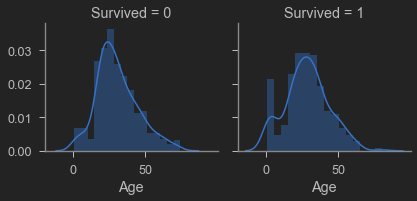

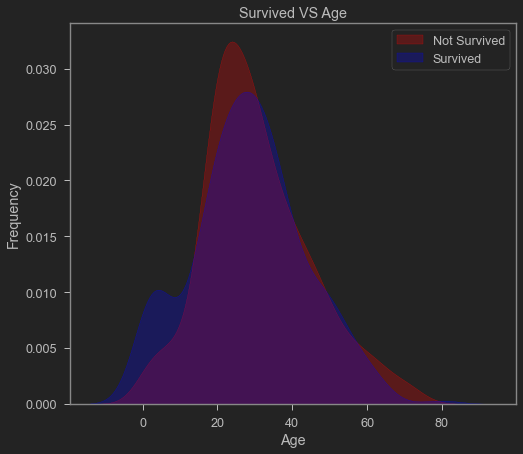

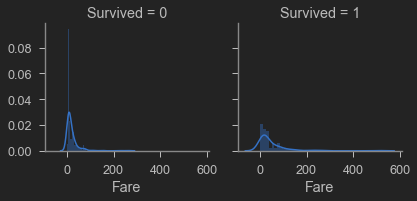

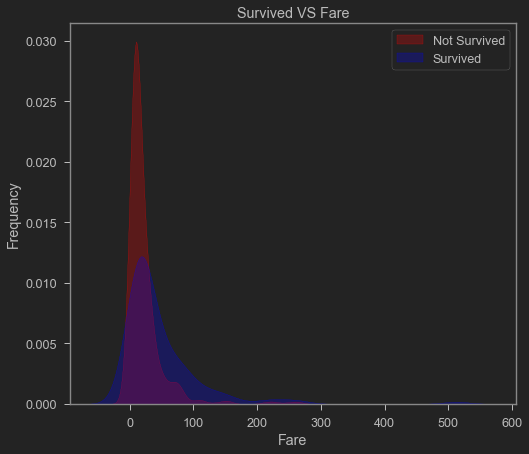

In [15]:
for i, c in enumerate([ _ for _ in type_dict["float64"] if _ != "Survived"],1):
#     plt.subplot(len(list([ _ for _ in type_dict["int64"]if _ != "Survived"])), 2, i)
    g = sns.FacetGrid(train, col='Survived')
    g = g.map(sns.distplot, c)
    plt.show()
    plt.title("Survived VS {}".format(c))
    g = sns.kdeplot(train[c][(train["Survived"] == 0) & (train[c].notnull())], color="Red", shade = True)
    g = sns.kdeplot(train[c][(train["Survived"] == 1) & (train[c].notnull())], ax =g, color="Blue", shade= True)
    g.set_xlabel(c)
    g.set_ylabel("Frequency")
    g = g.legend(["Not Survived","Survived"])
    plt.show()

# Anaylsis
* age vs survived
    * there appears to be a bit of a relation; however, requires further investigation
    * revamping of the plot method used demonstrates that there is a strong correlation between age and survival 
    * there is large concentration of young passengers surviving
    * there also appears to be more older passengers that did not survive
* fare vs survived
    * there is likely a relation here based upon the observations of pclass vs survival rate
    * a closer inspection is needed


In [16]:
# Explore Fare distribution 
numeric_dypes = type_dict["float64"]
# type_dict["int64"] + 
# numeric_dtypes
type_dict["float64"]

['Age', 'Fare']

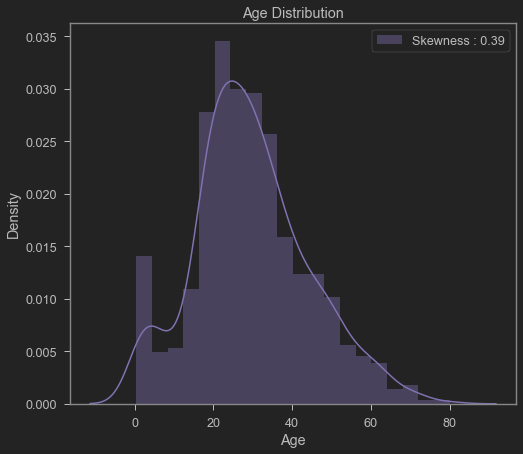

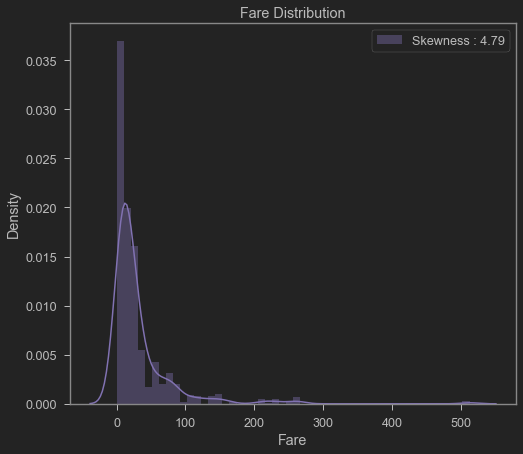

In [17]:
for c in type_dict["float64"]:
# + type_dict["int64"]:
    g = sns.distplot(train[c], color="m", label="Skewness : %.2f"%(train[c].skew()))
    g = g.legend(loc="best")
    plt.title("{} Distribution".format(c))
    plt.show()

Should one immediately apply a log transformation to create a gaussian? Why or why not? 
* The referenced notebook: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling applies a log transform on the feature "Fare". The justification is to reduce "...very high values in the model, even if it is scaled." What are the other perspectives to observe as a justification for the log transform?
* Age is not transformed in the referenced notebook in the prev bullet. Why not? It makes sense to not transform it because it'd lead to a misinterpretation of the data. It makes sense that there's a slightly higher proportion of young passengers surviving in contrast to older passengers who were more likely to no survive. An immediate conclusion to normalize the distro would obfuscate potential observations such as this.

In [18]:
type_dict["object"]

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

# object: Feature vs Target Feature Analysis


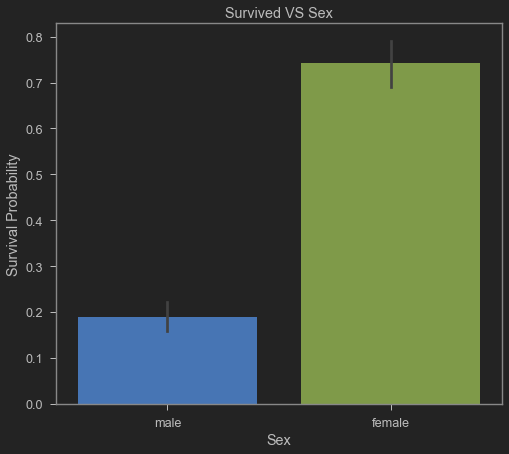

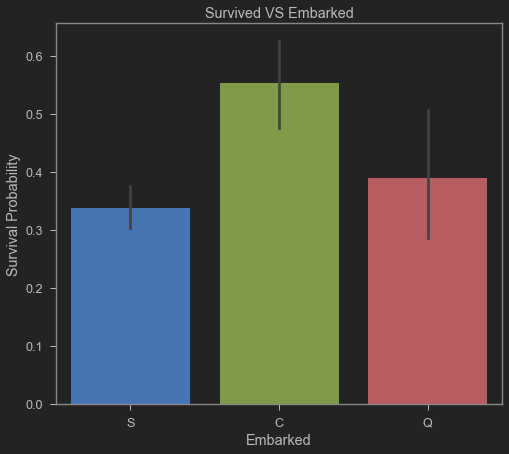

In [19]:
# for i, c in enumerate([ _ for _ in type_dict["object"] if _ != "Name"],1):
col_strtype = ["Sex", "Embarked"]
for c in col_strtype: 
#     plt.subplot(len(list([ _ for _ in type_dict["int64"]if _ != "Survived"])), 2, i)
    plt.title("Survived VS {}".format(c))
    g = sns.barplot(x=c,y="Survived",data=train)
    g = g.set_ylabel("Survival Probability")
    plt.show()
    

# Analysis
* sex vs survived
    * women were far more likely to survive in contrast to males per the quote from the movie "Women and children first!"
* embarked vs survived
    * naturally inclined to think that the port of embarkation is likely to have little to no relation with survival rate
    * a case for a relation to exist would be that the location may represent a culture of alertness to dangers suggesting a better prepared passenger for moments of danger
    * what is the significance of the location of embarkation?
    * what is the reason for passengers who embarked at Cherbourg having a higher survival chance?


# Cross Analyis of Dtypes

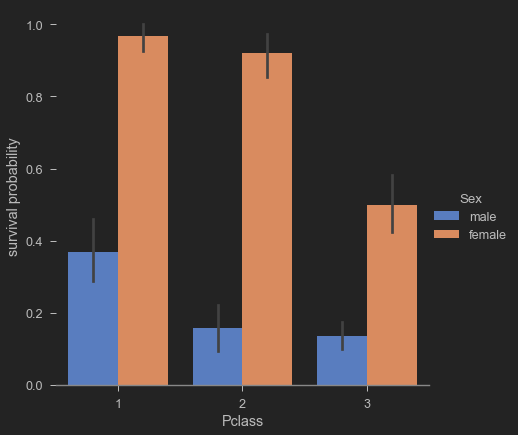

In [20]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")


# Analysis
Gender played a large role in determining survivability of a passenger. Women were more inclined to survive in contrast to men.  Regardless of controlling for SES, the trend of women being more inclined to survive was conserved. In additition, passengers of higher class were likely more likely to survive in contrast to lower SES passengers. 

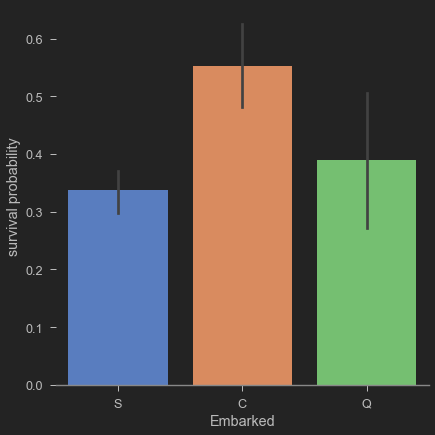

In [21]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")


Why is it that those embarking from Cherbourg were more likely to survive?
* Were they primarily women?
* Where they primarily of higher SES?

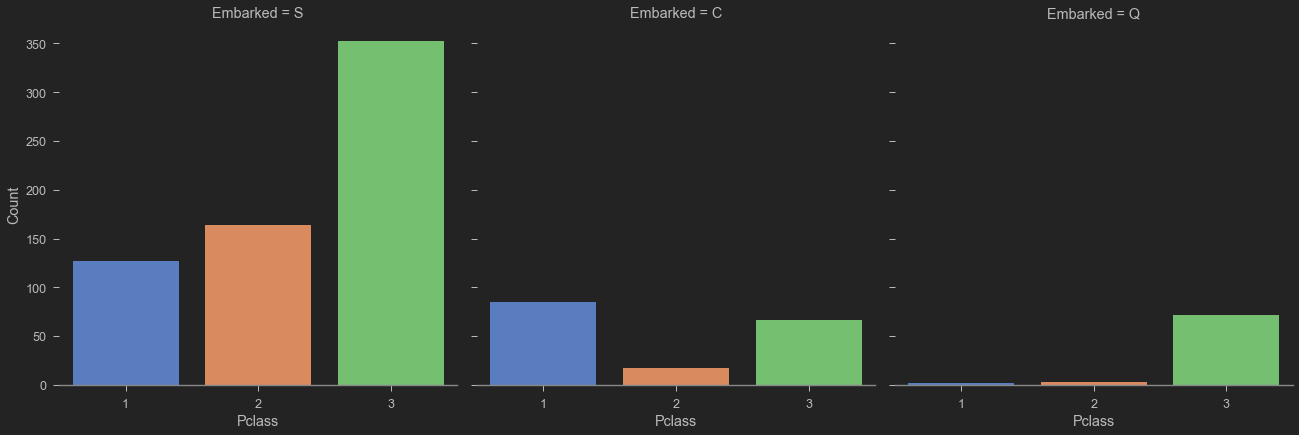

In [22]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")


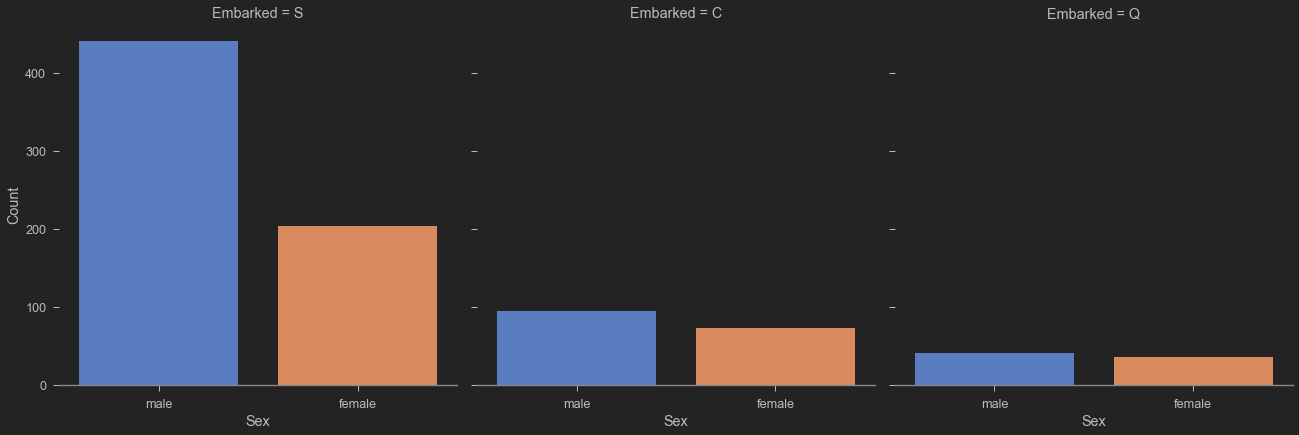

In [23]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Sex", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")


# Analysis
1. Q: Were they primarily women? 
- A: No, those from Southampton (S) were primarily men.  Cherbourg & Queenstown had a fairly even distribution of genders at the respective locations.
2. Q: Were they primarily of higher SES?
- A: Not necessarily conclusive across the board. There is a slightly higher distribution of 1st class passengers for  Cherbourg in contrast to the other locations. It would make sense that those embarking from  Cherbourg had some form of influence.

Main Q: Why is it that those embarking from Cherbourg were more likely to survive?
A: Passengers embarking from Cherbourg showed a higher distribution for 1st class passengers out of all 3 classes. It is likely, although not confirmed, that passengers of 1st class are probably aristocrats or indivusals that hold influence warranting their priotization during evac.

# Feature Imputation: Revisit
Recalling,
```sh
Age: 177 / 891 instances missing --> 19.86532%
Cabin: 687 / 891 instances missing --> 77.10438%
Embarked: 2 / 891 instances missing --> 0.22447%
```
Considering the second round of EDA and now the need for imputing features. One should consider the entirety of the dataset. The reason for observing the entirety of the dataset. The test set was initially excluded from EDA since it does not contain the random target variable to be predicted. To analyze supporting random feature variables would not be useful during EDA since analysis revolves around understanding of related support features in conjunction with the rand target var. 

For the case of feature imputation it's now important to consider the entirety of dataset -- the set of all instances (train + test) because one must identify all features columns containing missing values. Identification of these instances' features for imputation is important because one is able to draw from a larger picture when deriving values for filling in missing features. In addition, we also fill in the blanks all in one sweep. 

In [24]:
test_ids = test["PassengerId"]
train["PassengerId"] = train_ids
# test = test.drop("PassengerId",axis=1)

In [25]:
display(test.head())
display(train.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,5


In [26]:
full_data = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)
display(train.shape, test.shape, full_data.shape)
# len(full_data)
# full_data.head()

(891, 12)

(418, 11)

(1309, 12)

Note that it's okay for the test data shape to be one less than the training because the test set does not contain the target variable "Survived".

# Feature Imputation: Assessing Missing Values


# Feature Imputation: 4C's
1. Complete: impute values for missing cells
2. Correct: appropriate adjustment of distributions, removal of outliers
3. Create: generation of new features given existing features
4. Convert: hot encode ie conversion of object types to values accepted by the machine such as integer/float types 

# Feature Imputation: Correct

In [27]:
# Outlier detection 
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    
    Reference:  https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    """
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

The function detect_outliers is potentially faulty because it does NOT drop NaNs when calculating the percentiles.
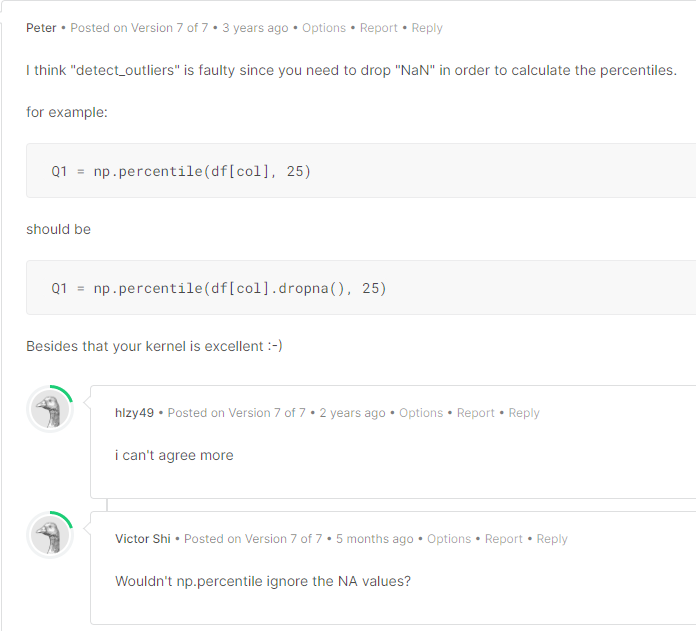

In [28]:
print("Training set outliers:", len(train.loc[outliers_to_drop]))
train.loc[outliers_to_drop]


Training set outliers: 10


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
27,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S,28
88,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S,89
159,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,160
180,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,181
201,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,202
324,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,325
341,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S,342
792,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,793
846,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,847
863,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,864


In [29]:
# Drop outliers
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

# Feature Imputation: Complete
Similar to first approach we find all missing values for any column from which we are able to identify the columns in need of imputation.


In [30]:
## Join train and test sets in order to obtain the same number of features during categorical conversion
train_len = len(train)
full_data =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
# Fill empty and NaNs values with NaN
full_data = full_data.fillna(np.nan)
# Check for Null values
full_data.isnull().sum()


Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
PassengerId       0
dtype: int64

In [31]:
def show_missing_report(df:pandas.DataFrame):
    all_cols = df.isna().any()
    na_cols = [c for c in all_cols.index if all_cols[c] == True]
    na_cols.remove("Survived") # random target feature column we DONT impute for
    display("All columns:",df.isna().any(), "Missing cols:", na_cols)
    print()
    for c in na_cols:
        na_count = df[c].isna().sum()
        total = len(df[c])
        na_percent =  na_count / total * 100
        print("{}: {} / {} instances missing --> {:1.5f}%".format(c, na_count, total, na_percent))
        

In [32]:
show_missing_report(full_data)        


'All columns:'

Survived        True
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked        True
PassengerId    False
dtype: bool

'Missing cols:'

['Age', 'Fare', 'Cabin', 'Embarked']


Age: 256 / 1299 instances missing --> 19.70747%
Fare: 1 / 1299 instances missing --> 0.07698%
Cabin: 1007 / 1299 instances missing --> 77.52117%
Embarked: 2 / 1299 instances missing --> 0.15396%


# Feature Imputation: Age
There exists 256 missing values in the whole dataset post-outliers removal. Given the prior observations from EDA, we know the feature age holds significance in passenger survival thus provides reason for keeping such a feature and suggests a need to fill in the blanks. An approach to imputing for this feature would be to observe the features that are most correlated with age. 

In [33]:
full_data.columns
# cols removed from plotting due to computational cost
insig_cols = ['PassengerId','Name',"Ticket","Fare","Cabin","Survived"] 
sig_cols = [ c for c in full_data.columns if c not in insig_cols]
sig_cols

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']

Pclass


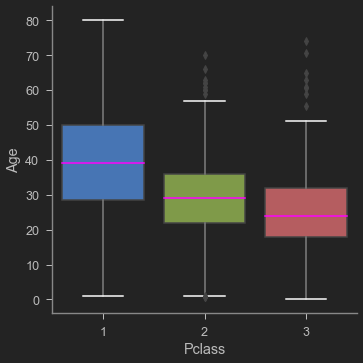

Sex


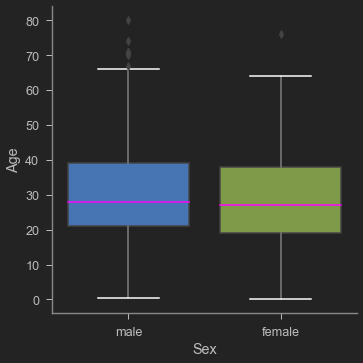

SibSp


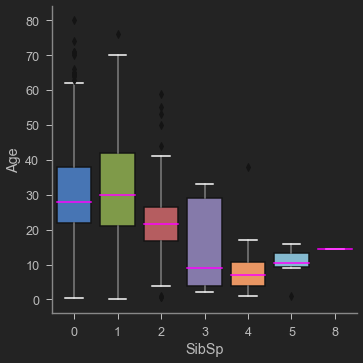

Parch


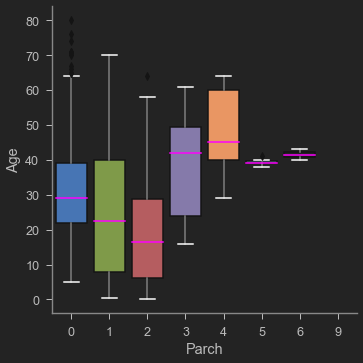

Embarked


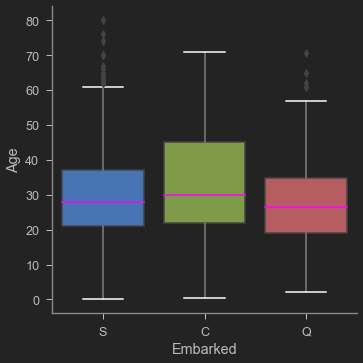

In [34]:
PROPS = {
#     'boxprops':{'facecolor':'none', 'edgecolor':'white'},
    'medianprops':{'color':'magenta'},
    'whiskerprops':{'color':'grey'},
    'capprops':{'color':'white'}
}

for c in [_ for _ in sig_cols if _ != "Age"]:
    print(c)
    g = sns.factorplot(y="Age",x=c,data=full_data,kind="box",**PROPS)
    plt.show()



['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']


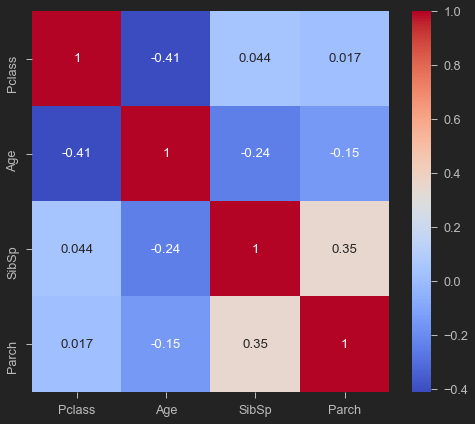

In [35]:
print(sig_cols) 
g = sns.heatmap(full_data[sig_cols].corr(),cmap="coolwarm",annot=True)
# does not plot "Sex" because the machine does not understand strings thus need to hot encode

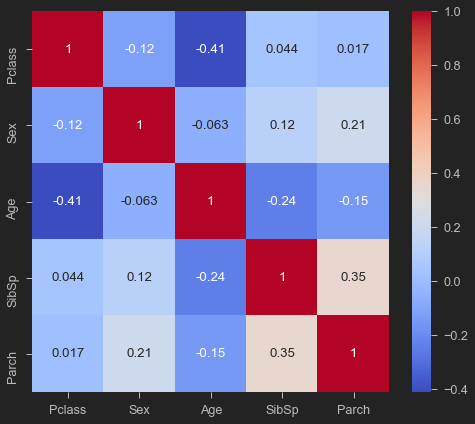

In [36]:
# map applies a transform given the key to be transformed to the associated value
full_data["Sex"] = full_data["Sex"].map({"male":0, "female":1}) 
g = sns.heatmap(full_data[sig_cols].corr(),cmap="coolwarm",annot=True)


Age is least correlated with sex. For all other features, there is a fair amount of correlation with "Pclass" being the largest. Apply imputation given the similarity between the feature criteria consisting of Pclass, Parch & SibSp.

In [37]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Indices of NaN age rows
index_NaN_age = list(full_data["Age"][full_data["Age"].isnull()].index) 

for i in index_NaN_age:
    age_med = full_data["Age"].median()
    # search for an instance matching with the feature-criteria
    age_pred = full_data["Age"][(
        (full_data['SibSp'] == full_data.iloc[i]["SibSp"]) & 
        (full_data['Parch'] == full_data.iloc[i]["Parch"]) & 
        (full_data['Pclass'] == full_data.iloc[i]["Pclass"]))].median()
    # check if there exists an instance whose correlated features associate to an age
    if not np.isnan(age_pred): 
        print("Filled using predicted value:", age_pred) # DEBUG
        full_data['Age'].iloc[i] = age_pred
    # case in which there does not exist a matching instance of the feature criteria
    else:
        print("Filled using median value:", age_med) # DEBUG
        full_data['Age'].iloc[i] = age_med

Filled using predicted value: 25.0
Filled using predicted value: 30.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 38.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 23.0
Filled using predicted value: 39.0
Filled using predicted value: 39.0
Filled using predicted value: 16.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 25.0
Filled using predicted value: 16.0
Filled using predict

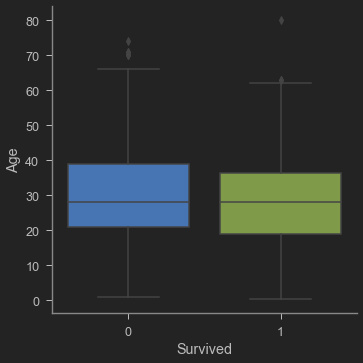

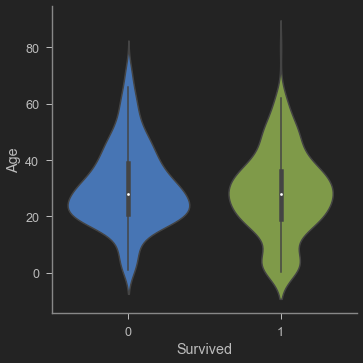

In [38]:
# Assessing quality of age imputation
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

# Analysis
Q: Why do we use a violin-plot here in contrast to a box-plot?<br>
A: Perhaps for better visualization of distributions? This makes sense since hte box-plot does not provide much assistance in contrasting surival rate given age. Using the violin-plot, we are able to better see taht there is a higher survival rate for those that are younger.<br>
* From the box-plot we can see that there is very little change in terms of the median age in those that survive and those that don't survive. 
* From the violin-plot we can see that there is a visible blip in the distribution denoting young passengers have a higher survival rate. 


In [39]:
show_missing_report(full_data)

'All columns:'

Survived        True
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked        True
PassengerId    False
dtype: bool

'Missing cols:'

['Fare', 'Cabin', 'Embarked']


Fare: 1 / 1299 instances missing --> 0.07698%
Cabin: 1007 / 1299 instances missing --> 77.52117%
Embarked: 2 / 1299 instances missing --> 0.15396%


Observing the remaining features to impute, we see that there are A LOT of missing instances for the cabin-feature. This makes me wonder if there is any relation/association between ticket numbers and cabin numbers. I doubt there would be any relation but it is worth at the very least taking a peek.

In [40]:
df_tix_cab= full_data[(
        (pd.notna(full_data['Cabin']) ) & 
        (pd.notna(full_data['Ticket'])))]
df_tix_cab.head(25)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,4
6,0.0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S,7
10,1.0,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,16.7000,G6,S,11
11,1.0,1,"Bonnell, Miss. Elizabeth",1,58.0,0,0,113783,26.5500,C103,S,12
21,1.0,2,"Beesley, Mr. Lawrence",0,34.0,0,0,248698,13.0000,D56,S,22
23,1.0,1,"Sloper, Mr. William Thompson",0,28.0,0,0,113788,35.5000,A6,S,24
30,1.0,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",1,38.0,1,0,PC 17569,146.5208,B78,C,32
51,1.0,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",1,49.0,1,0,PC 17572,76.7292,D33,C,53
53,0.0,1,"Ostby, Mr. Engelhart Cornelius",0,65.0,0,1,113509,61.9792,B30,C,55


# Feature Imputation: A Roadblock
No shot...<br>
Thus more referencing:
* Advance Feature Engineering: https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
    * <b>Notable Sections:</b>
        - EDA (notably the approach for handling the "Cabin" feature)
        - Feature Engineering
    * <b>My Takeaways & Reflections on Reading:</b>
        - Much of the data preparation portion of data science is an application of statistics in conjunction with programming to carry out detective work -- to figure out mysteries (whether it be the problem to be solved, or dealing with values that are missing)
        - Usage of existing knowledge (regardless of acute apparence) ie knowledge that exists that one may/may-not know of, but have a means and are permitted access to use
        - Thinking outside of the box (in this instance -- outside the realms of programming & stats) ie a consideration of reasonable potential solutions that were not considered (google search for particular features -- NOT the target variable ie the direct answers to the main problem)
        <br>
        
        
<img src="Titanic_side_plan.png" style="float: left; margin-right: 10px;" />



In [41]:
full_data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'B78', 'D33',
       'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12',
       'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2',
       'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31',
       'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94',
       'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D', 'C22 C26', 'C106',
       'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18',
       'C124', 'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82',
       'B96 B98', 'E10', 'E44', 'C23 C25 C27', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

In [42]:
import re
regex = r"([a-zA-Z])\d?"
test = 'F G73'
# print(test.split(" "))
# [re.findall(regex,e) for e in test.split(" ")]
re.findall(regex,test)

['F', 'G']

In [43]:
# Create deck method 1
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
full_data['Deck'] = full_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = full_data.groupby(['Deck','Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()
df_all_decks 

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  91  40  6  34  4  3  13  8  5  67  254  686  1

In [44]:
full_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId,Deck
0,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,1,M
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,C
2,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,M
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,4,C
4,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,5,M


In [45]:
full_data = full_data.drop("Deck", axis=1)

In [46]:
# creation of deck-feature using Series.apply(anon-func for row accessed given a column
# first character of each element in each cabin str)
# full_data['Deck'] = full_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M') 
# this can be checked by calling print inside of the apply to observe the behavior

# this is tehcnically a faulty approach 
# because certain instances have multiple DIFFERENT cabin labels pertaining to one instance
# this can be fixed by writing an algo using a regex or a func that iterates through each instance
# splits them up followed by a check for the map of 
for i, row in full_data.iterrows():
    deck_str = row["Cabin"]
    # verify value is not null 
    if not pd.notnull(deck_str):
        deck_str = "M" # M denoting missing
        cabin = [deck_str]
    else:
        cabins = re.findall(regex,deck_str)
    # more than one cabin occupied
#     if len(Deck_list) > 1:
#         print(deck_str)
#         print(Deck_list)
    cabins = re.findall(regex,deck_str)
    deck_count = Counter(cabins)
    if deck_str != "M" and len(deck_count.keys()) > 1: # DEBUG
        print(cabins)
        print(deck_count)
    for k in deck_count.keys():
        # initialized case
        if "Deck_{}".format(k) in full_data.columns:
        # assign value for the row at the particular instance
            full_data.loc[i,"Deck_{}".format(k)] = deck_count[k]
        # uninitializated case
        else:
            print("create new aarray")
            # create new np.array for feature
            full_data["Deck_{}".format(k)] = np.zeros(len(full_data))
            # assign value for feature at a particular row
            full_data.loc[i,"Deck_{}".format(k)] = deck_count[k]
        if "Deck" in full_data.columns:
            full_data.loc[i,"Deck"] = "".join(cabins)
        else:
            full_data["Deck"] = np.zeros(len(full_data))
            full_data.loc[i,"Deck"] = "".join(cabins)
            
    # create a Deck_{room} feature for each instance...? or new feature...? ie if Deck_F does not exist create it for the length
    # of the rows and tally the number occupied for the row instance..? at the particular row index...?
    # the sum of Deck_M is the sum of all miniumum cabins missing ie 1 cabin per row instance at the minimum, minimum because
    # some instances have more than 1 cabin

create new aarray
create new aarray
create new aarray
create new aarray
create new aarray
create new aarray
create new aarray
create new aarray
['F', 'G']
Counter({'F': 1, 'G': 1})
['F', 'E']
Counter({'F': 1, 'E': 1})
create new aarray
['F', 'G']
Counter({'F': 1, 'G': 1})
['F', 'G']
Counter({'F': 1, 'G': 1})
['F', 'G']
Counter({'F': 1, 'G': 1})
['F', 'E']
Counter({'F': 1, 'E': 1})
['F', 'E']
Counter({'F': 1, 'E': 1})


In [47]:
full_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId,Deck_M,Deck,Deck_C,Deck_E,Deck_G,Deck_D,Deck_A,Deck_B,Deck_F,Deck_T
0,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1.0,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,0.0,C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,1.0,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,4,0.0,C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,5,1.0,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df_all_decks = full_data.groupby(['Deck','Pclass']).count().drop(
    columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Cabin',
             'Fare', 'Embarked', 'PassengerId', 'Ticket'] + 
            [c for c in full_data.columns.to_list() if "Deck_" in c]
    ).rename(columns={'Name': 'Count'}).transpose()

df_all_decks

Deck     A   B BB BBB BBBB   C CC CCC   D    DD   E       EE   F    FE FG  G  \
Pclass   1   1  1   1    1   1  1   1   1  2  1   1  2  3  1   2  3  3  3  3   
Count   22  48  8   4    5  80  8   3  38  6  2  33  4  3  1  13  1  3  4  5   

Deck     M            T  
Pclass   1    2    3  1  
Count   67  254  686  1